In [4]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="out/cleaned-formatted.jsonl", split="train", streaming=True)


/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased", cache_dir="cache/")
model = AutoModel.from_pretrained("indolem/indobertweet-base-uncased", cache_dir="cache/")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31923, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Bucketing by only using token embeds

In [25]:
import torch
def getEncodings(textArray):
  inputs = tokenizer(
    textArray,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
  )
  with torch.no_grad():
    outputs = model(**inputs)
  cls_embeddings = outputs.last_hidden_state[:,0,:]
  return cls_embeddings.cpu().numpy()

In [27]:
def count_existing_lines(file_path):
    try:
        with open(file_path, "r") as f:
            return sum(1 for _ in f)
    except FileNotFoundError:
        return 0

### Converts token of the text into a feature array. The feature dimension is then reduced all the way down to just 50 axis.

In [28]:
from tqdm import tqdm
import json
embedings = []
batch_documents = []
batch = []
print("Getting embeds")
processed_count = count_existing_lines("out/cleaned-with-embed.jsonl")
print(f"Resuming from index {processed_count}")

for idx, example in enumerate(tqdm(dataset, desc="Resuming embedding")):
  if idx < processed_count:
    continue  # Already processed
  batch.append(example)
  if len(batch) == 16:
    texts = [doc["content"] for doc in batch]
    embeded_docs = getEncodings(texts)
    with open("out/cleaned-with-embed.jsonl", "a") as f:
      for doc, emb in zip(batch, embeded_docs):
        doc["embeds"] = emb.tolist()
        f.write(json.dumps(doc) + "\n")
    batch = []
    
if batch:
  texts = [doc["content"] for doc in batch]
  embeded_docs = getEncodings(texts)
  for doc, emb in zip(batch, embeded_docs):
    doc["embeds"] = emb
    with open("out/cleaned-with-embed.jsonl", "a") as f:
      for doc, emb in zip(batch, embeded_docs):
        doc["embeds"] = emb.tolist()
        f.write(json.dumps(doc) + "\n")

Getting embeds
Resuming from index 0


Resuming embedding: 201583it [1:27:03, 38.59it/s]


In [29]:
from sklearn.decomposition import PCA
import json
import numpy as np

data = []
with open("out/cleaned-with-embed.jsonl", "r", encoding="utf-8") as f:
  for line in f:
    doc = json.loads(line)
    data.append(doc)
embeds = [doc["embeds"] for doc in data]

pca = PCA(n_components=50)
reduced_embeddings = pca.fit_transform(np.array(embeds))

with open("out/cleaned-formatted.json", "r", encoding="utf-8") as f:
  rawjson = json.load(f)
  
with open("out/cleaned-with-reduced-embed.jsonl", "a", encoding="utf-8") as fl:
  for obj, embeds in zip(rawjson, reduced_embeddings):
    obj["embeds"] = embeds.tolist()
    fl.write(json.dumps(obj) + "\n")
      

In [ ]:
import re
import emoji
import numpy as np

def extract_structural_features(tweet):
  length = len(tweet)
  num_hashtags = tweet.count("#")
  num_mentions = tweet.count("@")
  num_urls = len(re.findall(r"http\S+", tweet))
  num_emojis = len([c for c in tweet if c in emoji.EMOJI_DATA])
  num_upper = sum(1 for c in tweet if c.isupper())
  num_punct = len(re.findall(r"[^\w\s]", tweet))
  avg_word_len = np.mean([len(w) for w in tweet.split()]) if tweet.split() else 0

  return [length, num_hashtags, num_mentions, num_urls,
          num_emojis, num_upper, num_punct, avg_word_len]

# Utilize DBSCAN

In [30]:
from sre_parse import Verbose
from sklearn.cluster import DBSCAN
import json
import numpy as np


dbscan = DBSCAN(eps=8.0, min_samples=4)

reduced_embed_documents = []
with open("out/cleaned-with-reduced-embed.jsonl", "r", encoding="utf-8") as filewithreducedembed:
  for line in filewithreducedembed:
    reduced_embed_documents.append(json.loads(line))
    
reduced_embeds = [doc["embeds"] for doc in reduced_embed_documents]

cluster_labels = dbscan.fit_predict(np.array(reduced_embeds))


with open("out/cleaned-formatted.json", "r", encoding="utf-8") as basejson:
  base_document = json.load(basejson)
  
for doc, label in zip(base_document, cluster_labels):
  doc["metadata"]["bucket_label"] = int(label)

base_document = sorted(base_document, key=lambda x: x["metadata"]["bucket_label"])

with open("out/cleaned-with-labels.json", "w", encoding="utf-8") as labeljson:
  json.dump(base_document, labeljson, indent=2, ensure_ascii=False)


# Utilize KMeans

In [2]:
from sre_parse import Verbose
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt
import numpy as np


kmeans = KMeans(n_clusters=4, random_state=42)

reduced_embed_documents = []

with open("out/cleaned-with-reduced-embed.jsonl", "r", encoding="utf-8") as filewithreducedembed:
  for line in filewithreducedembed:
    reduced_embed_documents.append(json.loads(line))
    
reduced_embeds = [doc["embeds"] for doc in reduced_embed_documents]
cluster_labels = kmeans.fit_predict(reduced_embeds)


with open("out/cleaned-formatted.json", "r", encoding="utf-8") as basejson:
  base_document = json.load(basejson)
  
for doc, label in zip(base_document, cluster_labels):
  doc["metadata"]["bucket_label"] = int(label)

base_document = sorted(base_document, key=lambda x: x["metadata"]["bucket_label"])

with open("out/cleaned-with-labels.json", "w", encoding="utf-8") as labeljson:
  json.dump(base_document, labeljson, indent=2, ensure_ascii=False)


# Utilize HDBSCAN

In [19]:
from sre_parse import Verbose
import hdbscan
import json
import matplotlib.pyplot as plt
import numpy as np


reduced_embed_documents = []

with open("out/cleaned-with-reduced-embed.jsonl", "r", encoding="utf-8") as filewithreducedembed:
  for line in filewithreducedembed:
    reduced_embed_documents.append(json.loads(line))
    
reduced_embeds = [doc["embeds"] for doc in reduced_embed_documents]
cluster_labels = hdbscan.HDBSCAN(min_cluster_size=20).fit(reduced_embeds).labels_


with open("out/cleaned-formatted.json", "r", encoding="utf-8") as basejson:
  base_document = json.load(basejson)
  
for doc, label in zip(base_document, cluster_labels):
  doc["metadata"]["bucket_label"] = int(label)

base_document = sorted(base_document, key=lambda x: x["metadata"]["bucket_label"])

with open("out/cleaned-with-labels.json", "w", encoding="utf-8") as labeljson:
  json.dump(base_document, labeljson, indent=2, ensure_ascii=False)


/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Expl

In [ ]:
import json
with open("out/embeded-data.json", "w") as f_out:
    json.dump(batch_documents, f_out, ensure_ascii=False, indent=2)

In [32]:
from collections import defaultdict
import re
import json
with open("out/cleaned-with-labels.json", "r", encoding="utf-8") as f:
  documents = json.load(f)

tweets = [doc["content"] for doc in documents]
labels = [doc["metadata"]["bucket_label"] for doc in documents]
buckets = defaultdict(list)


for tweet, label in zip(tweets, labels):
  buckets[label].append(tweet)

def count_hashtags(text):
  return len(re.findall(r"#\w+", text))

# Analyze each bucket
for label, bucket_tweets in buckets.items():
  hashtag_counts = [count_hashtags(tweet) for tweet in bucket_tweets]
  tweet_lengths = [len(tweet) for tweet in bucket_tweets]  # you could use len(tokenizer.tokenize(tweet)) if needed

  avg_hashtags = sum(hashtag_counts) / len(bucket_tweets)
  avg_length = sum(tweet_lengths) / len(bucket_tweets)
  longest_tweet = max(bucket_tweets, key=len)
  shortest_tweet = min(bucket_tweets, key=len)

  print(f"Bucket {label}:")
  print(f"  Average hashtags per tweet: {avg_hashtags:.2f}")
  print(f"  Average tweet length: {avg_length:.2f} characters")
  print(f"  Longest tweet: \"{longest_tweet}\"")
  print(f"  Shortest tweet: \"{shortest_tweet}\"")
  
  print()

Bucket 0:
  Average hashtags per tweet: 0.42
  Average tweet length: 155.47 characters
  Longest tweet: "yuk, kita bahas with chill brain & real data. 1. wait… kenapa ada yang minta ptfi ditutup? so lately ada aksi demo yang bilang freeport udah 58 tahun “ilegal” dan minta operasionalnya di-shutdown.penutupan operasional freeport, bakal banyak efek dominojawaban dari grok, perluas untuk melihat percakapan lengkapnyapenutupan operasional pt freeport indonesia pasti bakal picu efek domino yang luas, karena posisinya sebagai salah satu raksasa tambang di indonesia. berikut beberapa dampak potensial yang bisa terjadi, berdasarkan analisis dari berbagai sudut: ekonomi lokal dan nasional mimika lumpuh: sekitar 90% ekonomi kabupaten mimika bergantung pada freeport. penutupan bisa bikin roda ekonomi lokal macet, dari umkm sampai sektor jasa yang hidup dari aktivitas tambang. kehilangan pekerjaan: freeport mempekerjakan sekitar 30.471 orang (data mei 2024), termasuk 41% warga asli papua. phk ma

In [33]:
# Utility functions
from collections import Counter
import re
def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def hashtag_ratio(text):
    hashtags = ''.join(re.findall(r"#\w+", text))
    return len(hashtags) / len(text) if len(text) > 0 else 0

def extract_emojis(text):
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

def emoji_ratio(text):
    emojis = extract_emojis(text)
    return len(''.join(emojis)) / len(text) if len(text) > 0 else 0

def url_ratio(tweets):
    return sum(1 for t in tweets if re.search(r"http\S+", t)) / len(tweets)

def mention_ratio(tweets):
    return sum(1 for t in tweets if re.search(r"@\w+", t)) / len(tweets)

def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if words else 0

def repeated_char_abuse(text):
    return bool(re.search(r"(.)\1{3,}", text))

def duplicate_ratio(tweets):
    freq = Counter(tweets)
    return sum(count for tweet, count in freq.items() if count > 1) / len(tweets)


In [34]:
results = {}
for label, bucket_tweets in buckets.items():
    hashtag_counts = [count_hashtags(t) for t in bucket_tweets]
    tweet_lengths = [len(t) for t in bucket_tweets]
    hashtag_ratios = [hashtag_ratio(t) for t in bucket_tweets]
    emoji_ratios = [emoji_ratio(t) for t in bucket_tweets]
    lexical_divs = [lexical_diversity(t) for t in bucket_tweets]
    repeated_abuse_count = sum(1 for t in bucket_tweets if repeated_char_abuse(t))

    avg_hashtags = sum(hashtag_counts) / len(bucket_tweets)
    avg_length = sum(tweet_lengths) / len(bucket_tweets)
    avg_hashtag_ratio = sum(hashtag_ratios) / len(bucket_tweets)
    avg_emoji_ratio = sum(emoji_ratios) / len(bucket_tweets)
    avg_lexical_div = sum(lexical_divs) / len(bucket_tweets)
    url_ratio_val = url_ratio(bucket_tweets)
    mention_ratio_val = mention_ratio(bucket_tweets)
    dup_ratio = duplicate_ratio(bucket_tweets)

    # Heuristic label tagging
    label_tags = []
    if avg_length > 200:
        label_tags.append("long tweets")
    if avg_hashtag_ratio > 0.4:
        label_tags.append("hashtag-heavy")
    if avg_emoji_ratio > 0.2:
        label_tags.append("emoji spam")
    if url_ratio_val > 0.3:
        label_tags.append("link drop")
    if mention_ratio_val > 0.3:
        label_tags.append("mention spam")
    if avg_lexical_div < 0.4:
        label_tags.append("low diversity (copypasta)")
    if repeated_abuse_count / len(bucket_tweets) > 0.3:
        label_tags.append("repeated char abuse")
    if dup_ratio > 0.3:
        label_tags.append("high duplication")

    longest = max(bucket_tweets, key=len)
    shortest = min(bucket_tweets, key=len)

    results[label] = {
        "label": ", ".join(label_tags) if label_tags else "generic",
        "avg_hashtags": avg_hashtags,
        "avg_length": avg_length,
        "longest_tweet": longest,
        "shortest_tweet": shortest,
        "hashtag_ratio": avg_hashtag_ratio,
        "emoji_ratio": avg_emoji_ratio,
        "url_ratio": url_ratio_val,
        "mention_ratio": mention_ratio_val,
        "lexical_diversity": avg_lexical_div,
        "duplication_ratio": dup_ratio,
        "repeated_char_abuse_count": repeated_abuse_count,
    }

# Output the results
for label, metrics in results.items():
    print(f"\nCluster {label}: {metrics['label']}")
    for k, v in metrics.items():
        if k != 'label':
            print(f"  {k}: {v}")


Cluster 0: generic
  avg_hashtags: 0.420101275559259
  avg_length: 155.47217058735552
  longest_tweet: yuk, kita bahas with chill brain & real data. 1. wait… kenapa ada yang minta ptfi ditutup? so lately ada aksi demo yang bilang freeport udah 58 tahun “ilegal” dan minta operasionalnya di-shutdown.penutupan operasional freeport, bakal banyak efek dominojawaban dari grok, perluas untuk melihat percakapan lengkapnyapenutupan operasional pt freeport indonesia pasti bakal picu efek domino yang luas, karena posisinya sebagai salah satu raksasa tambang di indonesia. berikut beberapa dampak potensial yang bisa terjadi, berdasarkan analisis dari berbagai sudut: ekonomi lokal dan nasional mimika lumpuh: sekitar 90% ekonomi kabupaten mimika bergantung pada freeport. penutupan bisa bikin roda ekonomi lokal macet, dari umkm sampai sektor jasa yang hidup dari aktivitas tambang. kehilangan pekerjaan: freeport mempekerjakan sekitar 30.471 orang (data mei 2024), termasuk 41% warga asli papua. phk mas

# Bucketing only by using text features

In [1]:
import json
with open("out/cleaned-formatted.json", "r", encoding="utf-8") as file:
  document = json.load(file)

In [2]:
import re
import numpy as np
import emoji

def extract_structural_features(tweet):
    length = len(tweet)
    num_hashtags = tweet.count("#")
    num_mentions = tweet.count("@")
    num_urls = len(re.findall(r"http\S+", tweet))
    num_emojis = len([c for c in tweet if c in emoji.EMOJI_DATA])
    num_upper = sum(1 for c in tweet if c.isupper())
    num_punct = len(re.findall(r"[^\w\s]", tweet))
    
    words = tweet.split()
    avg_word_len = np.mean([len(w) for w in words]) if words else 0

    # Lexical diversity: unique / total
    lexical_diversity = len(set(words)) / len(words) if words else 0

    # Repeated character abuse (e.g., "sooo", "nooooo")
    repeated_char_abuse = len(re.findall(r"(.)\1{2,}", tweet))

    return [
        length,
        num_hashtags,
        num_mentions,
        num_urls,
        num_emojis,
        num_upper,
        num_punct,
        avg_word_len,
        lexical_diversity,
    ]

In [3]:
import numpy as np
feature_array = []
for doc in document:
  features = extract_structural_features(doc["content"])
  feature_array.append(features)

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
np_feature_array = np.array(feature_array)
feature_array_scaled = scaler.fit_transform(np_feature_array)

for doc in feature_array_scaled[:10]:
  print(doc)

[ 0.31759166 -0.26069952 -0.02344217  0.         -0.02198024 -0.04645357
 -0.27091859 -0.60564852  0.61368225]
[-1.12919393 -0.52357419 -0.02344217  0.         -0.02198024 -0.04645357
 -1.03757238 -0.34875265  0.61368225]
[-0.05084442  0.00217516 -0.02344217  0.         -0.02198024 -0.04645357
 -0.65424549 -0.27742535  0.61368225]
[ 0.48833033  1.31654853 -0.02344217  0.         -0.02198024 -0.04645357
  1.45405243 -0.56593515 -1.18859732]
[-1.0842627  -0.52357419 -0.02344217  0.         -0.02198024 -0.04645357
 -1.03757238 -0.48774945  0.61368225]
[-0.77873034 -0.26069952 -0.02344217  0.         -0.02198024 -0.04645357
 -0.84590893 -0.59041754  0.61368225]
[ 0.83879392 -0.52357419 -0.02344217  0.         -0.02198024 -0.04645357
  0.1124083  -0.49285963 -0.65851509]
[-0.02388568 -0.26069952 -0.02344217  0.         -0.02198024 -0.04645357
  0.1124083  -0.70493195  0.16311236]
[-0.93149652 -0.26069952 -0.02344217  0.         -0.02198024 -0.04645357
 -0.65424549 -0.14025746  0.61368225]
[

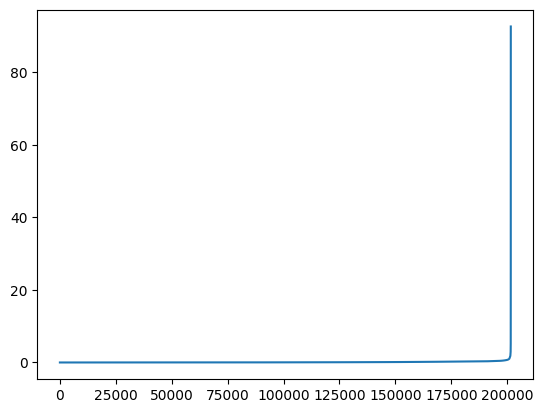

In [16]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(feature_array_scaled)
distances, _ = nbrs.kneighbors(feature_array_scaled)
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.show()


In [ ]:
from sklearn.cluster import DBSCAN
import json
import numpy as np

dbscan = DBSCAN(eps=10.0, min_samples=5)

cluster_labels = dbscan.fit_predict(np.array(feature_array))

with open("out/cleaned-formatted.json", "r", encoding="utf-8") as basejson:
  base_document = json.load(basejson)
  
for doc, label in zip(base_document, cluster_labels):
  doc["metadata"]["bucket_label"] = int(label)

base_document = sorted(base_document, key=lambda x: x["metadata"]["bucket_label"])

with open("out/feature-only-cleaned-with-labels.json", "w", encoding="utf-8") as labeljson:
  json.dump(base_document, labeljson, indent=2, ensure_ascii=False)


In [13]:
import hdbscan
import json
import numpy as np

dbscan = hdbscan.HDBSCAN(min_cluster_size=9000, min_samples=100)

cluster_labels = dbscan.fit_predict(feature_array_scaled)

with open("out/cleaned-formatted.json", "r", encoding="utf-8") as basejson:
  base_document = json.load(basejson)
  
for doc, label in zip(base_document, cluster_labels):
  doc["metadata"]["bucket_label"] = int(label)

base_document = sorted(base_document, key=lambda x: x["metadata"]["bucket_label"])

with open("out/feature-only-cleaned-with-labels.json", "w", encoding="utf-8") as labeljson:
  json.dump(base_document, labeljson, indent=2, ensure_ascii=False)


/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [14]:
from collections import defaultdict
import re
import json

with open("out/feature-only-cleaned-with-labels.json", "r", encoding="utf-8") as file:
    documents = json.load(file)

buckets = defaultdict(list)
tweets = [doc["content"] for doc in documents]
labels = [doc["metadata"]["bucket_label"] for doc in documents]

for tweet, label in zip(tweets, labels):
  buckets[label].append(tweet)

from collections import Counter
import re
def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def hashtag_ratio(text):
    hashtags = ''.join(re.findall(r"#\w+", text))
    return len(hashtags) / len(text) if len(text) > 0 else 0

def extract_emojis(text):
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                               "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

def emoji_ratio(text):
    emojis = extract_emojis(text)
    return len(''.join(emojis)) / len(text) if len(text) > 0 else 0


def url_ratio(tweets):
    return sum(1 for t in tweets if re.search(r"http\S+", t)) / len(tweets)

def mention_ratio(tweets):
    return sum(1 for t in tweets if re.search(r"@\w+", t)) / len(tweets)

def lexical_diversity(text):
    words = text.split()
    return len(set(words)) / len(words) if words else 0

def repeated_char_abuse(text):
    return bool(re.search(r"(.)\1{3,}", text))

def duplicate_ratio(tweets):
    freq = Counter(tweets)
    return sum(count for tweet, count in freq.items() if count > 1) / len(tweets)
results = {}
for label, bucket_tweets in buckets.items():
    hashtag_counts = [count_hashtags(t) for t in bucket_tweets]
    tweet_lengths = [len(t) for t in bucket_tweets]
    hashtag_ratios = [hashtag_ratio(t) for t in bucket_tweets]
    emoji_ratios = [emoji_ratio(t) for t in bucket_tweets]
    lexical_divs = [lexical_diversity(t) for t in bucket_tweets]
    repeated_abuse_count = sum(1 for t in bucket_tweets if repeated_char_abuse(t))

    avg_hashtags = sum(hashtag_counts) / len(bucket_tweets)
    avg_length = sum(tweet_lengths) / len(bucket_tweets)
    avg_hashtag_ratio = sum(hashtag_ratios) / len(bucket_tweets)
    avg_emoji_ratio = sum(emoji_ratios) / len(bucket_tweets)
    avg_lexical_div = sum(lexical_divs) / len(bucket_tweets)
    url_ratio_val = url_ratio(bucket_tweets)
    mention_ratio_val = mention_ratio(bucket_tweets)
    dup_ratio = duplicate_ratio(bucket_tweets)

    # Heuristic label tagging
    label_tags = []
    if avg_length > 200:
        label_tags.append("long tweets")
    if avg_hashtag_ratio > 0.4:
        label_tags.append("hashtag-heavy")
    if avg_emoji_ratio > 0.2:
        label_tags.append("emoji spam")
    if url_ratio_val > 0.3:
        label_tags.append("link drop")
    if mention_ratio_val > 0.3:
        label_tags.append("mention spam")
    if avg_lexical_div < 0.4:
        label_tags.append("low diversity (copypasta)")
    if repeated_abuse_count / len(bucket_tweets) > 0.3:
        label_tags.append("repeated char abuse")
    if dup_ratio > 0.3:
        label_tags.append("high duplication")

    longest = max(bucket_tweets, key=len)
    shortest = min(bucket_tweets, key=len)

    results[label] = {
        "label": ", ".join(label_tags) if label_tags else "generic",
        "avg_hashtags": avg_hashtags,
        "avg_length": avg_length,
        "longest_tweet": longest,
        "shortest_tweet": shortest,
        "hashtag_ratio": avg_hashtag_ratio,
        "emoji_ratio": avg_emoji_ratio,
        "url_ratio": url_ratio_val,
        "mention_ratio": mention_ratio_val,
        "lexical_diversity": avg_lexical_div,
        "duplication_ratio": dup_ratio,
        "repeated_char_abuse_count": repeated_abuse_count,
    }

# Output the results
for label, metrics in results.items():
    print(f"\nCluster {label}: {metrics['label']}")
    for k, v in metrics.items():
        if k != 'label':
            print(f"  {k}: {v}")


Cluster -1: long tweets
  avg_hashtags: 4.264682826514095
  avg_length: 215.34022213851588
  longest_tweet: buat yang suka demo atau protes, mending kalian serang yang ini. ada puluhan ribu triliun di situ. rebut, kaya jaman penjajahan belanda duludaftar perusahaan asing yang menguasai sda indonesia dan jumlah keuntungannyaanswer by grokberikut adalah daftar beberapa perusahaan asing yang mengelola sumber daya alam (sda) di indonesia, khususnya di sektor pertambangan dan migas, berdasarkan informasi yang tersedia. namun, data spesifik mengenai jumlah keuntungan sering kali tidak diungkap secara rinci dalam sumber publik karena bersifat rahasia perusahaan atau hanya dilaporkan secara agregat. saya akan mencantumkan perusahaan-perusahaan yang dikenal memiliki peran besar dalam pengelolaan sda indonesia beserta informasi keuntungan yang tersedia dari sumber terpercaya. jika data keuntungan tidak tersedia, saya akan menjelaskan kontribusi atau operasi mereka. pt freeport indonesia (freepo